In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


2024-02-10 13:09:32.909797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 13:09:32.909935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 13:09:33.062532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Imports and functions

In [4]:
import torchvision
import engine_boosted
import helper_functions

In [5]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [6]:
import torch
torch.set_num_threads(20)

In [7]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [8]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [9]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [10]:
tf_class = {
    'ATF2': 0,
    'ATF3': 1,
    'CEBPB': 2,
    'CREB1': 3,
    'CTCF': 4,
    'E2F4': 5,
    'EGR1': 6,
    'EFL1': 7,
    'ELK1': 8,
    'FOS': 9,
    'FOXA1': 10,
    'GABPA': 11,
    'JUN': 12,
    'JUND': 13,
    'MAFK': 14,
    'MAX': 15,
    'MAZ': 16,
    'MXI1': 17,
    'MYC': 18,
    'NRF1': 19,
    'RELA': 20,
    'REST': 21,
    'RFX5': 22,
    'SP1': 23,
    'SRF': 24,
    'TCF7L2': 25,
    'TCF12': 26,
    'TEAD4': 27,
    'USF1': 28,
    'USF2': 29,
    'YY1': 30,
    'ZBTB33': 31,
    'ZNF274': 32
}

# Set up device agnostic code

In [11]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_chrom_200/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_6_data.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


In [12]:
master_df = pd.read_csv('/kaggle/input/transcription-factor-binding-sites-data/combined_data_chrom_regs.csv')

In [13]:
master_df

,chrom,region,data,class,TF
0,chr1,Enhancer,CATTCTTTTCTCTGATGACCTCATCTATTCTCATGATTTC,1,ATF2
1,chr1,Enhancer,TTTACTGATTCTCAATGATCTCACATCATTCGATTACCTT,1,ATF2
2,chr6,Promoter,GGTAATTATCCGTGGATGACGACAGATGCCAGTTTTGCCC,1,ATF2
3,chr4,Enhancer,GTTATTCAATATTTTATACATGAGGACAGACCGAAAGAGA,1,ATF2
4,chr11,Promoter,TGTGCTGGTGCAGTAGTAACGTCATCCTTCCTTTACAGAG,1,ATF2
...,...,...,...,...,...
1204211,chr5,not_regulatory,GAATTCATACTGGAGAGAAACCTTACAAGTGTAATGAATG,0,ZNF274
1204212,chr19,not_regulatory,ACTCATTACACTTGTAAGGTTTCTCTCCAGTATGAACTCT,0,ZNF274
1204213,chr19,not_regulatory,CTCATTACACTTGTAAGGTTTCTCTCCAGTATGAACTCTC,0,ZNF274
1204214,chr1,not_regulatory,AGAATTCATACTGGAGAGAAACCTTACAAGTGTGAAGAAT,0,ZNF274


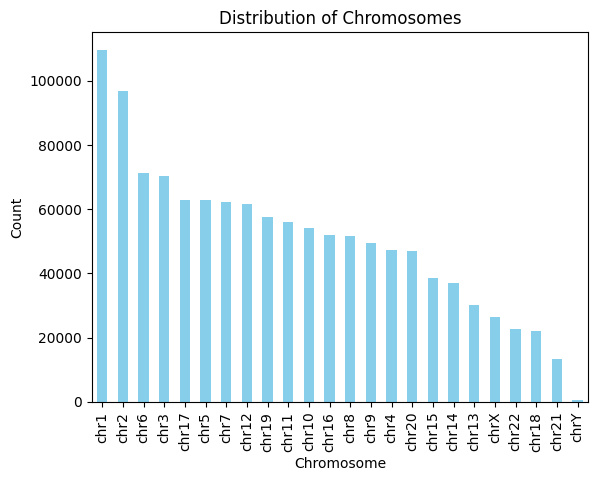

In [14]:
chromosome_counts = master_df['chrom'].value_counts()

# Plotting the histogram
chromosome_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Count')
plt.show()

In [15]:
print("Unique values in 'TF' column before mapping:", master_df['TF'].unique())


Unique values in 'TF' column before mapping: ['ATF2' 'ATF3' 'CEBPB' 'CREB1' 'CTCF' 'E2F4' 'EGR1' 'ELF1' 'ELK1' 'FOS'
 'FOXA1' 'GABPA' 'JUN' 'JUND' 'MAFK' 'MAX' 'MAZ' 'MXI1' 'MYC' 'NRF1'
 'RELA' 'REST' 'RFX5' 'SP1' 'SRF' 'TCF12' 'TCF7L2' 'TEAD4' 'USF1' 'USF2'
 'YY1' 'ZBTB33' 'ZNF274']


In [16]:
# Apply the mapping to the 'TF' column
master_df['TF'] = master_df['TF'].map(tf_class)

# Drop rows with NaN values in the 'TF' column
master_df = master_df.dropna(subset=['TF'])

# Convert the 'TF' column to integers
master_df['TF'] = master_df['TF'].astype(int)
master_df

/tmp/ipykernel_34/3393081513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['TF'] = master_df['TF'].astype(int)


,chrom,region,data,class,TF
0,chr1,Enhancer,CATTCTTTTCTCTGATGACCTCATCTATTCTCATGATTTC,1,0
1,chr1,Enhancer,TTTACTGATTCTCAATGATCTCACATCATTCGATTACCTT,1,0
2,chr6,Promoter,GGTAATTATCCGTGGATGACGACAGATGCCAGTTTTGCCC,1,0
3,chr4,Enhancer,GTTATTCAATATTTTATACATGAGGACAGACCGAAAGAGA,1,0
4,chr11,Promoter,TGTGCTGGTGCAGTAGTAACGTCATCCTTCCTTTACAGAG,1,0
...,...,...,...,...,...
1204211,chr5,not_regulatory,GAATTCATACTGGAGAGAAACCTTACAAGTGTAATGAATG,0,32
1204212,chr19,not_regulatory,ACTCATTACACTTGTAAGGTTTCTCTCCAGTATGAACTCT,0,32
1204213,chr19,not_regulatory,CTCATTACACTTGTAAGGTTTCTCTCCAGTATGAACTCTC,0,32
1204214,chr1,not_regulatory,AGAATTCATACTGGAGAGAAACCTTACAAGTGTGAAGAAT,0,32


In [17]:
# Select chromosomes for test set (e.g., 'chr1' and 'chr2')
test_chromosomes = ['chr1', 'chr2']
test_df = master_df[master_df['chrom'].isin(test_chromosomes)]

# Select chromosomes for training set (excluding 'chr1' and 'chr2')
train_df = master_df[~master_df['chrom'].isin(test_chromosomes)]

# Print the shapes of train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (982801, 5)
Test set shape: (204215, 5)


# Sequence length inspection and normalization

Max length:40, Min length: 40


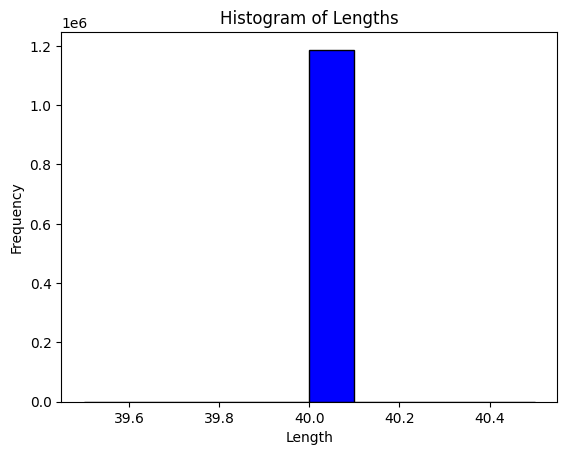

In [18]:
lengths= [len(item) for item in master_df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Create train, valid, test Dataloaders


In [19]:
X=[one_hot_encode(sequence) for sequence in train_df['data']]

In [20]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [21]:
X.shape

torch.Size([982801, 40, 4])

In [22]:
#y=np.array(df['TF'])
y=np.array(train_df['class'])

y[:3]

array([1, 1, 1])

In [23]:
y = torch.from_numpy(y).type(torch.float)

In [24]:
train_loader, valid_loader = helper_functions.make_2loaders(X,y)

In [25]:
X=[one_hot_encode(sequence) for sequence in test_df['data']]
X = torch.from_numpy(np.array(X)).type(torch.float)
y=np.array(test_df['class'])
y = torch.from_numpy(y).type(torch.float)
test_loader = helper_functions.make_loader(X,y)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [26]:
class Conv_v1(torch.nn.Module):

    def __init__(self):
        super(Conv_v1, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels= 30, kernel_size= 5)
        self.conv2 = torch.nn.Conv1d(in_channels= 30, out_channels= 30, kernel_size= 3)
        self.conv3 = torch.nn.Conv1d(in_channels= 30, out_channels= 30, kernel_size= 3)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size= 2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=2)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x=self.dropout(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x=self.dropout(x)
        
        x = self.conv3(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x=self.dropout(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        #x=self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Set up loss function and optimizer

In [27]:
from torch.optim import lr_scheduler


In [28]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v1()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.BCEWithLogitsLoss()

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Define exponetntial lr with lr_scheduler
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [30]:
num_classes_model

2

In [31]:
results, _ = engine_boosted.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=valid_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=10000,
                                                  device=device)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6868 | train_bal_acc: 0.5495 | train_mcc: 0.1011 | valid_loss: 0.6740 | valid_bal_acc: 0.5832 | valid_mcc: 0.1702  |  valid_auroc: 0.5832
Epoch: 2 | train_loss: 0.6708 | train_bal_acc: 0.5837 | train_mcc: 0.1732 | valid_loss: 0.6650 | valid_bal_acc: 0.5945 | valid_mcc: 0.2006  |  valid_auroc: 0.5945
Epoch: 3 | train_loss: 0.6645 | train_bal_acc: 0.5926 | train_mcc: 0.1967 | valid_loss: 0.6602 | valid_bal_acc: 0.6013 | valid_mcc: 0.2225  |  valid_auroc: 0.6013
Epoch: 4 | train_loss: 0.6607 | train_bal_acc: 0.5981 | train_mcc: 0.2111 | valid_loss: 0.6565 | valid_bal_acc: 0.6063 | valid_mcc: 0.2334  |  valid_auroc: 0.6063
Epoch: 5 | train_loss: 0.6578 | train_bal_acc: 0.6025 | train_mcc: 0.2220 | valid_loss: 0.6536 | valid_bal_acc: 0.6095 | valid_mcc: 0.2393  |  valid_auroc: 0.6095
Epoch: 6 | train_loss: 0.6558 | train_bal_acc: 0.6054 | train_mcc: 0.2282 | valid_loss: 0.6517 | valid_bal_acc: 0.6119 | valid_mcc: 0.2456  |  valid_auroc: 0.6119
Epoch: 7 | train_loss:

In [32]:
range(len(results["train_loss"]))

range(0, 97)

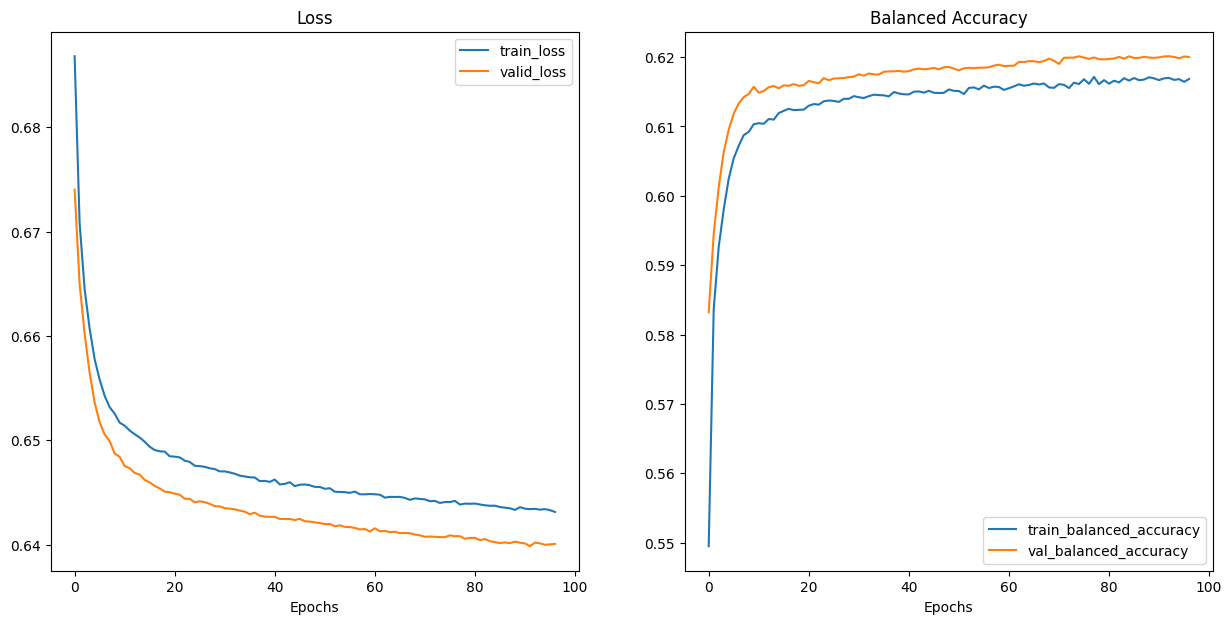

In [33]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

In [34]:
helper_functions.plot_auroc(results)

KeyError: 'train_auroc'

In [ ]:
helper_functions.plot_f_score(results)

In [35]:
test_results = engine_boosted.test_step(model = model,
                                        dataloader = test_loader,
                                        loss_fn = loss_fn,
                                        device =device)

In [36]:
# Unpack the values
test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = test_results

print("Perfomance on held out test set")
print(f'Test loss: {float(test_loss)}  | Test bal acc {float(test_bal_acc)} |\
Test mcc {float(test_mcc)} | Test_f_score {float(test_f_score)} | Test auroc {float(test_auroc)}')   
    

Perfomance on held out test set
Test loss: 0.6473931696713064  | Test bal acc 0.6093648691866276 |Test mcc 0.23298478796546426 | Test_f_score 0.5934429619566685 | Test auroc 0.6093648691866276
